# Comparison of MSB with counting simple cycles 

In [1]:
import random
import pickle
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from msb import Balance
from msb.cycleindex import balance_ratio

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.3,
    palette="deep"
)

COLORS = np.array(["#7aa063", "#c86b57", "#9d6ebd"])
RED    = "#f97959"
BLUE   = "#60a1f7"
GRAY   = "#efefef"

# Paths
HERE = Path(".").absolute()
ROOT = HERE.parent
DATA = ROOT/"data"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Balance params
BKWS = dict(m=None)

# Network datasets
LABELS = {
    "new-guinea-tribes":   "Tribes",
    "sampson/t1":          "Monks (1)",
    "sampson/t2":          "Monks (2)",
    "sampson/t3":          "Monks (3)",
    "sampson/t4":          "Monks (4)",
    "sampson/t5":          "Monks (5)",
}
NETWORKS = {
    name: ig.Graph.Read_GraphMLz(DATA/f"{label}.graphml.gz")
    for label, name in LABELS.items()
}

/home/sztal/.conda/envs/msb/lib/python3.10/site-packages/igraph/io/files.py:189: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  return cls.Read_GraphML(tmpfile, index=index)


In [2]:
def get_A(graph: ig.Graph) -> np.ndarray:
    """Get adjacency array."""
    return np.array([*graph.get_adjacency(attribute="weight")])

BALANCE = { 
    k: Balance(v, **BKWS) 
    for k, v in tqdm(NETWORKS.items())
}
CYCLES  = { 
    k: balance_ratio(get_A(v), v.vcount())
    for k, v in tqdm(NETWORKS.items())
}

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
data = []
for name, B in BALANCE.items():
    cycle = np.clip(1-CYCLES[name], 0, 1)
    K = B.K(kmax=B.n_nodes)
    msb = B.local_balance(K=K)
    contrib = B.contrib(K=K)
    df = pd.DataFrame({
        "cycle":   cycle[-K.size:],
        "msb":     msb,
        "contrib": contrib.to_numpy()
    }, index=pd.Series(K, name="K"))
    data.append(df)

data = pd.concat(data, keys=pd.Series(list(BALANCE), name="name"))

In [4]:
relerr

NameError: name 'relerr' is not defined

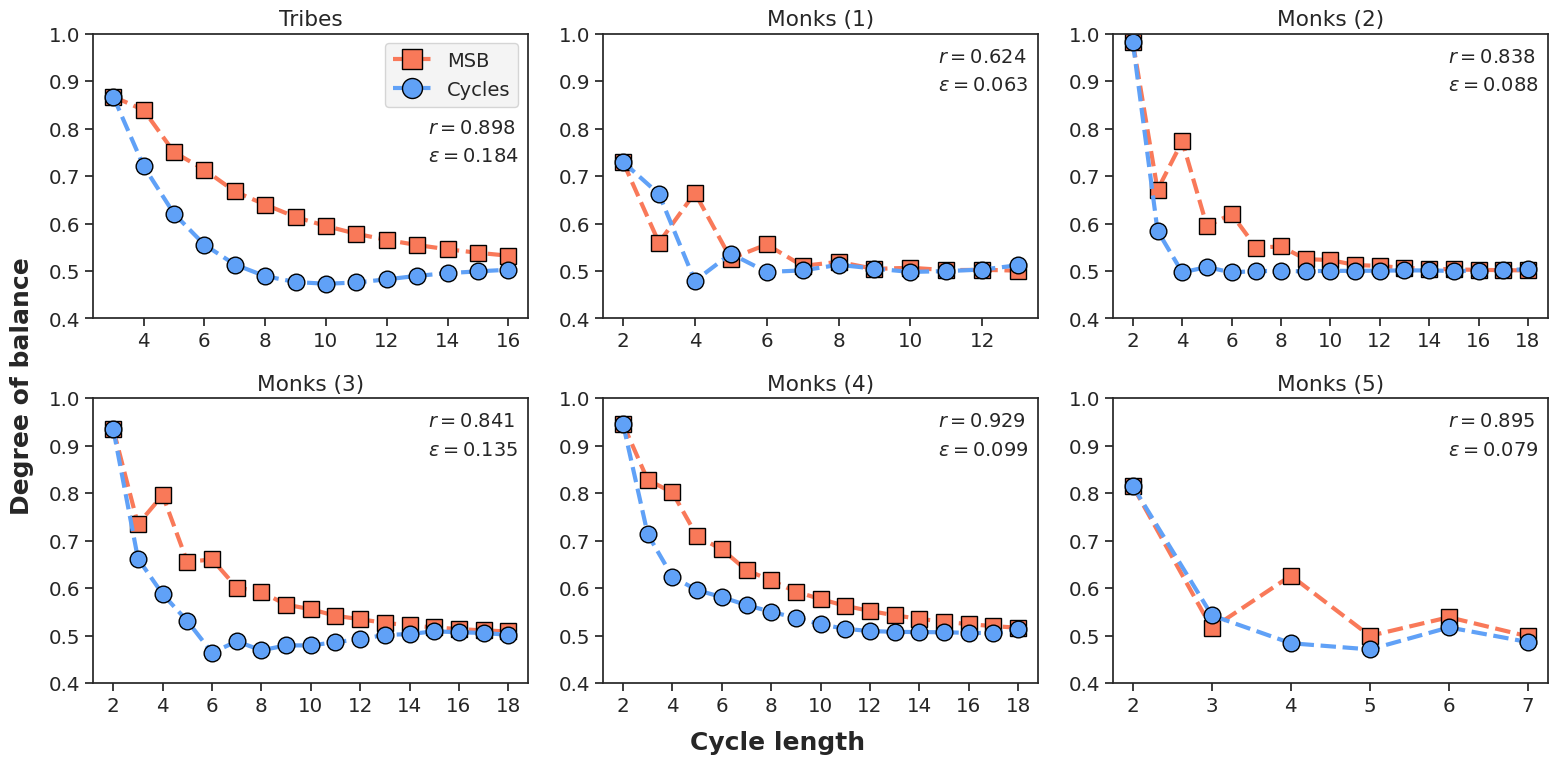

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

for ax, group in zip(axes.flatten(), data.groupby(level="name", sort=False)):
    name, gdf = group
    K = gdf.index.get_level_values("K")
    kws = {"ls": "--", "lw": 3, "markersize": 12, "markeredgecolor": "black"}
    ax.plot(K, gdf["msb"], marker="s", color=RED, **kws, label="MSB") 
    ax.plot(K, gdf["cycle"], marker="o", color=BLUE, **kws, label="Cycles")
    ax.set_title(name)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_ylim(.4, 1)
    # Correlation
    r = gdf.corr(method="pearson").loc["cycle", "msb"]
    relerr = np.abs((gdf["msb"] - gdf["cycle"]) / gdf["cycle"]).mean()
    # Legend and annotations
    t1 = rf"$r = {r:.3f}$"
    t2 = rf"$\epsilon = {relerr:.3f}$"
    akws = {"fontsize": 14, "transform": ax.transAxes}
    if name == "Tribes":
        ax.text(.77, .65, t1, **akws)
        ax.text(.77, .55, t2, **akws)
        ax.legend(fontsize=14, markerscale=1.2, facecolor="#f2f2f2")
    else:
        ax.text(.77, .9, t1, **akws)
        ax.text(.77, .8, t2, **akws)

fonts = {"fontsize": 18, "fontweight": "bold"}
fig.supxlabel("Cycle length", y=.04, **fonts) 
fig.supylabel("Degree of balance", **fonts)
fig.tight_layout()

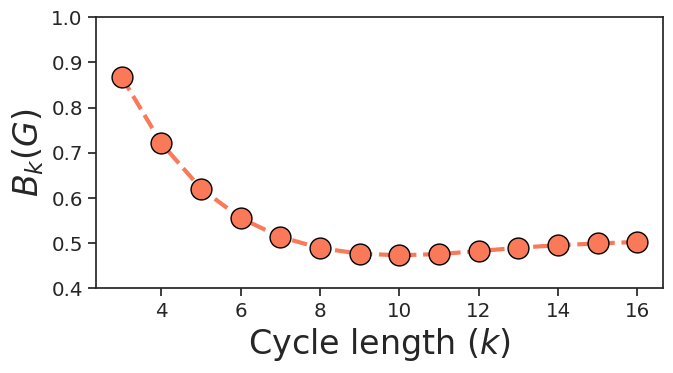

In [40]:
df = data.loc["Tribes"]

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(
    df.index, df["cycle"], ls="--", lw=3, color=RED,
    marker="o", markersize=15, markeredgecolor="black"
)
ax.set_ylim(.4, 1)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
ax.set_xlabel(r"Cycle length ($k$)", fontsize=24)
ax.set_ylabel(r"$B_k(G)$", fontsize=24)

fig.tight_layout()
fig.savefig(FIGS/"cycles.pdf", bbox_inches="tight")